In [1]:
import json
import datetime

import warnings
import geopandas
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import shap
import lightgbm as lgb

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score

/home/YAdetbekov/.local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/YAdetbekov/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
register_matplotlib_converters()
warnings.filterwarnings('ignore')

## Reading data

In [4]:
with open("data/data.json") as f:
    data = json.load(f)
    
df = pd.json_normalize(data["features"])
df = df.drop(["type"], axis=1)

In [5]:
df.head()

,id,properties.mag,properties.place,properties.time,properties.updated,properties.tz,properties.url,properties.detail,properties.felt,properties.cdi,...,properties.types,properties.nst,properties.dmin,properties.rms,properties.gap,properties.magType,properties.type,properties.title,geometry.type,geometry.coordinates
0,us6000ii6e,4.4,"34 km SW of Karaton, Kazakhstan",1661921583565,1662936976040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,",origin,phase-data,",20.0,5.295,0.95,173.0,mb,earthquake,"M 4.4 - 34 km SW of Karaton, Kazakhstan",Point,"[53.1206, 46.2671, 10]"
1,us7000i2jj,4.3,"51 km SW of Kuqa, China",1661504219657,1662464431040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,",origin,phase-data,",27.0,3.015,0.62,122.0,mb,earthquake,"M 4.3 - 51 km SW of Kuqa, China",Point,"[82.5527, 41.3469, 10]"
2,us6000iczv,4.3,"117 km ENE of Aksu, China",1661253152672,1661524797040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,",origin,phase-data,",35.0,2.231,0.41,125.0,mb,earthquake,"M 4.3 - 117 km ENE of Aksu, China",Point,"[81.5186, 41.6785, 10]"
3,us6000icze,4.0,"105 km NNE of Aral, China",1661249011795,1661525985040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,",origin,phase-data,",19.0,2.528,1.16,204.0,mb,earthquake,"M 4.0 - 105 km NNE of Aral, China",Point,"[81.7281, 41.4217, 10]"
4,us6000iab7,4.3,"151 km SSE of Kadzhi-Say, Kyrgyzstan",1660325737736,1662406933040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,",origin,phase-data,",59.0,0.805,1.15,70.0,mb,earthquake,"M 4.3 - 151 km SSE of Kadzhi-Say, Kyrgyzstan",Point,"[78.0355, 40.9426, 10]"


In [6]:
df["properties.type"].value_counts()

earthquake           2629
nuclear explosion     213
explosion               2
Name: properties.type, dtype: int64

## Filter earthquakes only

In [7]:
df = df[df["properties.type"] == "earthquake"]

## Normalize time

In [8]:
df["time"] = df["properties.time"].apply(lambda x: datetime.datetime.fromtimestamp(round(int(x)*0.001)))
df["updated"] = df["properties.updated"].apply(lambda x: datetime.datetime.fromtimestamp(round(int(x)*0.001)))
df["year"] = df["time"].apply(lambda x: int(str(x)[:4]))

## Distribution by years

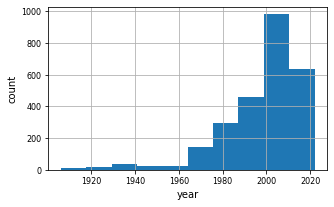

In [15]:
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['axes.labelsize'] = 10
df["year"].hist()
plt.xlabel("year")
plt.ylabel("count")
plt.savefig("yearly_distribution.png", dpi=200, bbox_inches='tight')

In [16]:
colors = ["#003366", "#E31B23", "#005CAB", "#DCEEF3", "#FFC325", "#E6F1EE"]
sns.set_palette(sns.color_palette(colors))

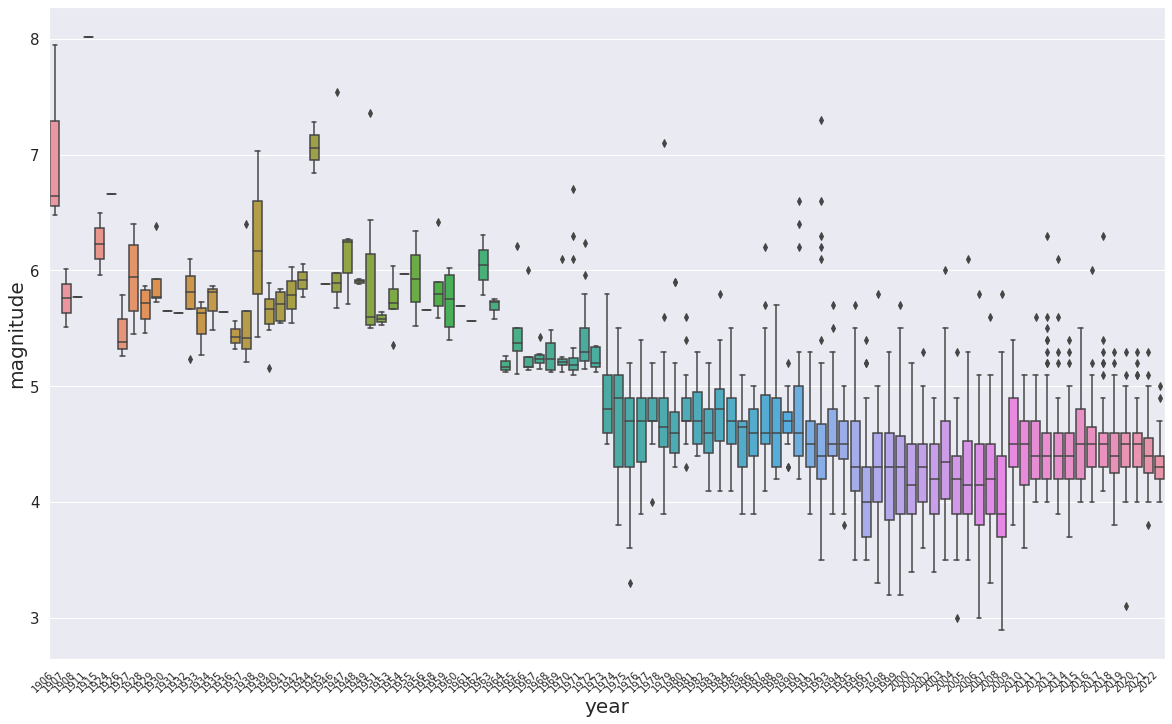

In [18]:
sns.set(rc={'figure.figsize':(20,12)})
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 20
sns.boxplot(data=df[df["properties.mag"]!=0], x="year", y="properties.mag", )
plt.ylabel("magnitude")
plt.xticks(rotation=45, ha="right")
plt.savefig("boxplot_yearly.png", dpi=200, bbox_inches='tight')
plt.show()

In [24]:
df

,id,properties.mag,properties.place,properties.time,properties.updated,properties.tz,properties.url,properties.detail,properties.felt,properties.cdi,...,properties.rms,properties.gap,properties.magType,properties.type,properties.title,geometry.type,geometry.coordinates,time,updated,year
0,us6000ii6e,4.40,"34 km SW of Karaton, Kazakhstan",1661921583565,1662936976040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,0.95,173.0,mb,earthquake,"M 4.4 - 34 km SW of Karaton, Kazakhstan",Point,"[53.1206, 46.2671, 10]",2022-08-31 10:53:04,2022-09-12 04:56:16,2022
1,us7000i2jj,4.30,"51 km SW of Kuqa, China",1661504219657,1662464431040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,0.62,122.0,mb,earthquake,"M 4.3 - 51 km SW of Kuqa, China",Point,"[82.5527, 41.3469, 10]",2022-08-26 14:57:00,2022-09-06 17:40:31,2022
2,us6000iczv,4.30,"117 km ENE of Aksu, China",1661253152672,1661524797040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,0.41,125.0,mb,earthquake,"M 4.3 - 117 km ENE of Aksu, China",Point,"[81.5186, 41.6785, 10]",2022-08-23 17:12:33,2022-08-26 20:39:57,2022
3,us6000icze,4.00,"105 km NNE of Aral, China",1661249011795,1661525985040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,1.16,204.0,mb,earthquake,"M 4.0 - 105 km NNE of Aral, China",Point,"[81.7281, 41.4217, 10]",2022-08-23 16:03:32,2022-08-26 20:59:45,2022
4,us6000iab7,4.30,"151 km SSE of Kadzhi-Say, Kyrgyzstan",1660325737736,1662406933040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,1.15,70.0,mb,earthquake,"M 4.3 - 151 km SSE of Kadzhi-Say, Kyrgyzstan",Point,"[78.0355, 40.9426, 10]",2022-08-12 23:35:38,2022-09-06 01:42:13,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2839,iscgemsup610326333,6.01,"95 km SE of Kadzhi-Say, Kyrgyzstan",-1965876386520,1652109571088,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,NaN,NaN,mw,earthquake,"M 6.0 - 95 km SE of Kadzhi-Say, Kyrgyzstan",Point,"[77.902, 41.471, 15]",1907-09-16 00:21:21,2022-05-09 21:19:31,1907
2840,iscgem610548696,5.51,"90 km ENE of Novokayakent, Russia",-1968086922420,1650919291577,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,NaN,NaN,mw,earthquake,"M 5.5 - 90 km ENE of Novokayakent, Russia",Point,"[48.965, 42.775, 15]",1907-08-21 10:19:06,2022-04-26 02:41:32,1907
2841,iscgem16957935,7.95,"95 km WSW of Shihezi, China",-1988948327200,1650918480767,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,NaN,NaN,mw,earthquake,"M 8.0 - 95 km WSW of Shihezi, China",Point,"[84.93, 43.988, 15]",1906-12-22 23:29:01,2022-04-26 02:28:01,1906
2842,iscgem610548671,6.48,"79 km W of Kuqa, China",-1992407256750,1650919256031,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,NaN,NaN,mw,earthquake,"M 6.5 - 79 km W of Kuqa, China",Point,"[81.979, 41.635, 15]",1906-11-12 22:40:11,2022-04-26 02:40:56,1906


## Converting to geopandas df

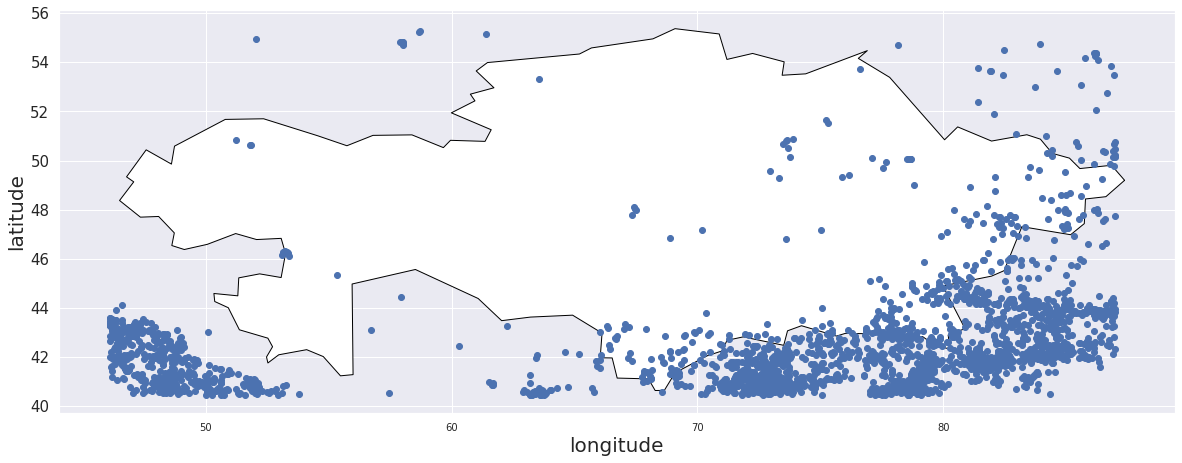

In [27]:
df["longitude"] = df["geometry.coordinates"].apply(lambda x: x[0])
df["latitude"] = df["geometry.coordinates"].apply(lambda x: x[1])

gdf = geopandas.GeoDataFrame(
    df,
    geometry = geopandas.points_from_xy(df["longitude"], df["latitude"])
)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.iso_a3 == 'KAZ'].plot(color='white', edgecolor='black')
gdf.plot(ax=ax)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.savefig("map.png", dpi=200, bbox_inches='tight')
plt.show()

## Save to enrich coordinates with administrative areas names

In [192]:
# df.to_csv("earthquakes.csv", sep="\t", index=False)

## Read file with regions

In [30]:
geocoded_earthquakes = pd.read_csv("geocoded_earthquakes.csv", sep="\t")

In [53]:
geocoded_earthquakes

,lng,lat,zid_id,city,REGION
0,63.544,53.321,11500930465,NaN,Костанайская область
1,51.243,50.844,11500148460,NaN,Западно-Казахстанская область
2,51.788,50.647,11500180912,NaN,Западно-Казахстанская область
3,51.834,50.634,11500184353,NaN,Западно-Казахстанская область
4,76.610,53.729,115002241021,NaN,Павлодарская область
...,...,...,...,...,...
191,78.081,42.949,115002372129,NaN,Алматинская область
192,78.662,42.825,115002419320,NaN,Алматинская область
193,77.840,44.230,115002351316,NaN,Алматинская область
194,80.287,44.165,115002535549,NaN,Алматинская область


In [34]:
geocoded_earthquakes.value_counts("REGION")

REGION
Алматинская область               89
Восточно-Казахстанская область    48
Туркестанская область             25
Жамбылская область                13
Карагандинская область             9
Кызылординская область             4
Западно-Казахстанская область      3
Костанайская область               1
Мангистауская область              1
Павлодарская область               1
dtype: int64

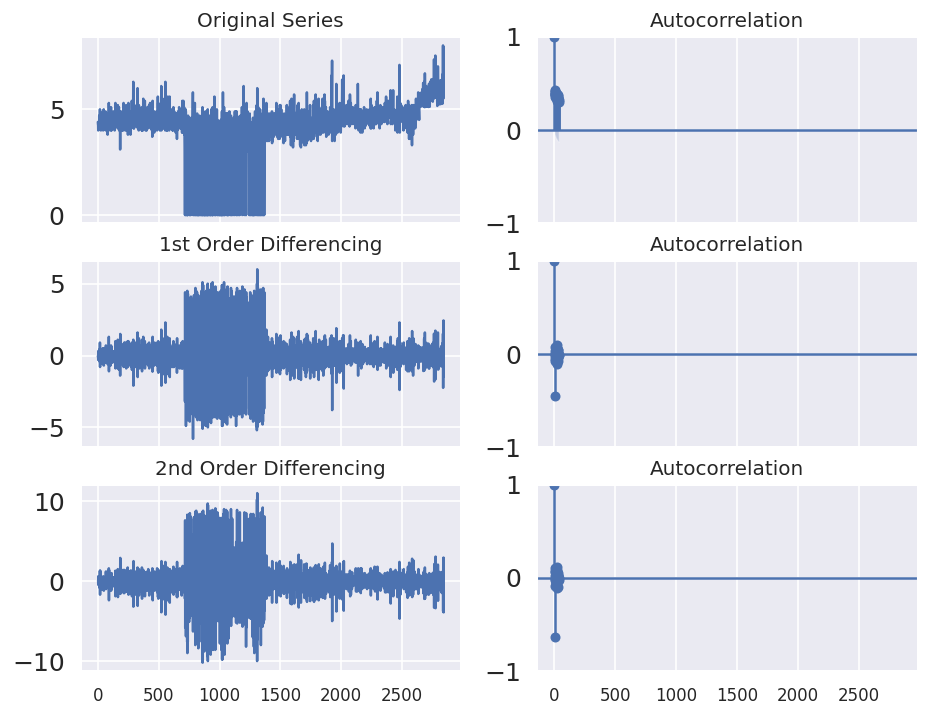

In [35]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
# df = geocoded_earthquakes

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df["properties.mag"]); axes[0, 0].set_title('Original Series')
plot_acf(df["properties.mag"], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df["properties.mag"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df["properties.mag"].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df["properties.mag"].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df["properties.mag"].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [36]:
from statsmodels.tsa.stattools import adfuller

# Run test
result = adfuller(df.groupby("year").sum()['properties.mag'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])

# Print critical values
print(result[4]) 

-0.6588088920943278
0.8571324875880162
{'1%': -3.5019123847798657, '5%': -2.892815255482889, '10%': -2.583453861475781}


## Join with regions

In [39]:
# geocoded_earthquakes["latitude"] = geocoded_earthquakes["lat"]
# geocoded_earthquakes["longitude"] = geocoded_earthquakes["lng"]

geocoded_earthquakes = geocoded_earthquakes[["latitude", "longitude", "REGION"]].drop_duplicates()

gdf_with_region = geopandas.GeoDataFrame(
    geocoded_earthquakes, 
    geometry = geopandas.points_from_xy(
        geocoded_earthquakes["longitude"], 
        geocoded_earthquakes["latitude"]
    )
)
data = geopandas.sjoin_nearest(gdf, gdf_with_region.drop(["latitude", "longitude"], axis=1))

In [40]:
gdf_with_region

,latitude,longitude,REGION,geometry
0,53.321,63.544,Костанайская область,POINT (63.54400 53.32100)
1,50.844,51.243,Западно-Казахстанская область,POINT (51.24300 50.84400)
2,50.647,51.788,Западно-Казахстанская область,POINT (51.78800 50.64700)
3,50.634,51.834,Западно-Казахстанская область,POINT (51.83400 50.63400)
4,53.729,76.610,Павлодарская область,POINT (76.61000 53.72900)
...,...,...,...,...
191,42.949,78.081,Алматинская область,POINT (78.08100 42.94900)
192,42.825,78.662,Алматинская область,POINT (78.66200 42.82500)
193,44.230,77.840,Алматинская область,POINT (77.84000 44.23000)
194,44.165,80.287,Алматинская область,POINT (80.28700 44.16500)


In [41]:
data.head()

,id,properties.mag,properties.place,properties.time,properties.updated,properties.tz,properties.url,properties.detail,properties.felt,properties.cdi,...,geometry.type,geometry.coordinates,time,updated,year,longitude,latitude,geometry,index_right,REGION
0,us6000ii6e,4.4,"34 km SW of Karaton, Kazakhstan",1661921583565,1662936976040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,Point,"[53.1206, 46.2671, 10]",2022-08-31 10:53:04,2022-09-12 04:56:16,2022,53.1206,46.2671,POINT (53.12060 46.26710),29,Мангистауская область
5,us6000icss,4.2,None,1660303601392,1661231407040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,Point,"[50.4971, 40.7588, 10]",2022-08-12 17:26:41,2022-08-23 11:10:07,2022,50.4971,40.7588,POINT (50.49710 40.75880),29,Мангистауская область
7,us6000i61s,4.1,"30 km NE of Q?rm?z? Samux, Azerbaijan",1658965702916,1661395579355,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,1.0,1.0,...,Point,"[46.615, 41.1508, 10]",2022-07-28 05:48:23,2022-08-25 08:46:19,2022,46.6150,41.1508,POINT (46.61500 41.15080),29,Мангистауская область
10,us6000i3mh,4.3,"143 km ENE of Pirallah?, Azerbaijan",1658237178335,1659035061040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,Point,"[51.7986, 41.1133, 11.6]",2022-07-19 19:26:18,2022-07-29 01:04:21,2022,51.7986,41.1133,POINT (51.79860 41.11330),29,Мангистауская область
20,us6000hzcx,4.1,"17 km NNW of Lagodekhi, Georgia",1656750295430,1658306125040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,Point,"[46.1925, 41.9689, 10]",2022-07-02 14:24:55,2022-07-20 14:35:25,2022,46.1925,41.9689,POINT (46.19250 41.96890),29,Мангистауская область


In [42]:
data["REGION"].isna().value_counts()

False    2627
True        2
Name: REGION, dtype: int64

In [43]:
data = data[~data["REGION"].isna()]

## Normalize main features

In [44]:
data["depth"] = data["geometry.coordinates"].apply(lambda x: x[2])
data["mag"] = data["properties.mag"]

In [53]:
data["mag_gt_5"] = data["mag"] > 5

## Plot depth

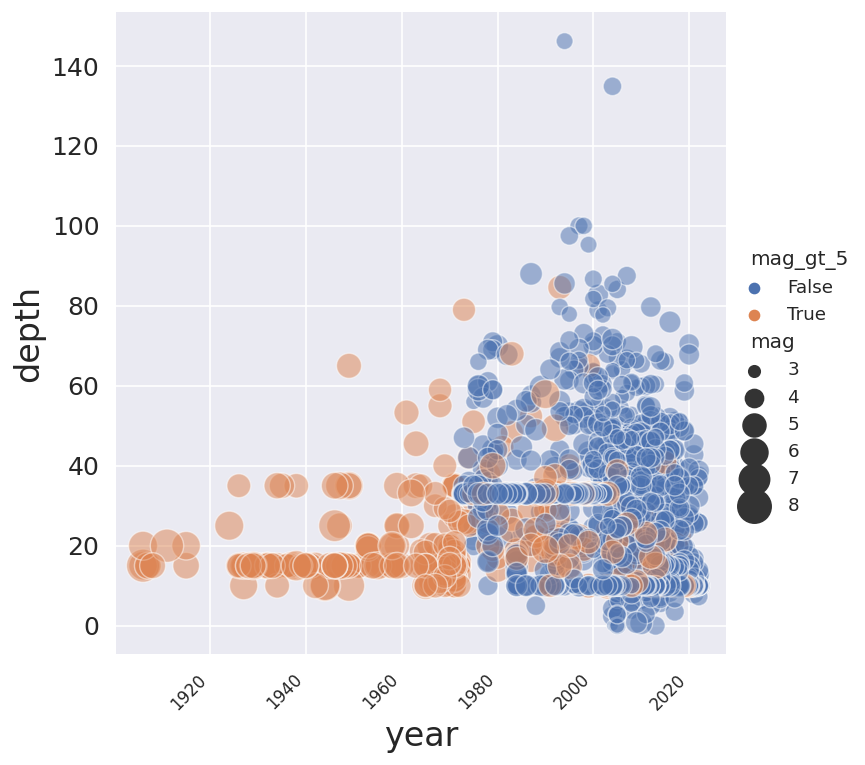

In [54]:
sns.set(rc={'figure.figsize':(20,12)})
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 20
sns.relplot(data=data[data["mag"]!=0], x="year", y="depth", hue="mag_gt_5", size="mag",
            sizes=(40, 400), alpha=.5,
            height=6)
plt.ylabel("depth")
plt.xticks(rotation=45, ha="right")
plt.savefig("retplot.png", dpi=200, bbox_inches='tight')
plt.show()

## Aggregate features

In [90]:
agg = data[[
    "mag", "year", "REGION", "depth"
]].groupby(["REGION", "year"]).agg({
    "mag" : ['mean', 'count', "min", "median", "max", "std"],
    "depth": ['mean', 'count', "min", "median", "max", "std"],
})
agg

mag                                     \
                             mean count   min median   max       std   
REGION                year                                             
Алматинская область   1906  6.560     2  6.48   6.56  6.64  0.113137   
                      1907  6.010     1  6.01   6.01  6.01       NaN   
                      1911  8.020     1  8.02   8.02  8.02       NaN   
                      1915  6.230     2  5.96   6.23  6.50  0.381838   
                      1926  5.380     1  5.38   5.38  5.38       NaN   
...                           ...   ...   ...    ...   ...       ...   
Туркестанская область 2018  4.500     1  4.50   4.50  4.50       NaN   
                      2019  4.600     3  4.40   4.60  4.80  0.200000   
                      2020  4.575     4  4.40   4.50  4.90  0.236291   
                      2021  4.250     4  4.20   4.25  4.30  0.057735   
                      2022  4.400     2  4.30   4.40  4.50  0.141421   

                                depth                                        
                                 mean count    min median    max        std  
REGION                year                                                   
Алматинская область   1906  17.500000     2  15.00  17.50  20.00   3.535534  
                      1907  15.000000     1  15.00  15.00  15.00        NaN  
                      1911  20.000000     1  20.00  20.00  20.00        NaN  
                      1915  17.500000     2  15.00  17.50  20.00   3.535534  
                      1926  15.000000     1  15.00  15.00  15.00        NaN  
...                               ...   ...    ...    ...    ...        ...  
Туркестанская область 2018  12.290000     1  12.29  12.29  12.29        NaN  
                      2019  22.896667     3  10.00  10.00  48.69  22.337682  
                      2020  18.585000     4  10.00  12.45  39.44  14.093908  
                      2021  10.000000     4  10.00  10.00  10.00   0.000000  
                      2022  10.000000     2  10.00  10.00  10.00   0.000000  

[403 rows x 12 columns]

In [94]:
train = agg.reset_index()
train.columns = ['_'.join(col) for col in train.columns]

In [96]:
train = train.sort_values(by=["REGION_", "year_"])

In [97]:
train

,REGION_,year_,mag_mean,mag_count,mag_min,mag_median,mag_max,mag_std,depth_mean,depth_count,depth_min,depth_median,depth_max,depth_std
0,Алматинская область,1906,6.560,2,6.48,6.56,6.64,0.113137,17.500000,2,15.00,17.50,20.00,3.535534
1,Алматинская область,1907,6.010,1,6.01,6.01,6.01,NaN,15.000000,1,15.00,15.00,15.00,NaN
2,Алматинская область,1911,8.020,1,8.02,8.02,8.02,NaN,20.000000,1,20.00,20.00,20.00,NaN
3,Алматинская область,1915,6.230,2,5.96,6.23,6.50,0.381838,17.500000,2,15.00,17.50,20.00,3.535534
4,Алматинская область,1926,5.380,1,5.38,5.38,5.38,NaN,15.000000,1,15.00,15.00,15.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,Туркестанская область,2018,4.500,1,4.50,4.50,4.50,NaN,12.290000,1,12.29,12.29,12.29,NaN
399,Туркестанская область,2019,4.600,3,4.40,4.60,4.80,0.200000,22.896667,3,10.00,10.00,48.69,22.337682
400,Туркестанская область,2020,4.575,4,4.40,4.50,4.90,0.236291,18.585000,4,10.00,12.45,39.44,14.093908
401,Туркестанская область,2021,4.250,4,4.20,4.25,4.30,0.057735,10.000000,4,10.00,10.00,10.00,0.000000


In [100]:
print(f"min year: {train['year_'].min()} \nmax_year: {train['year_'].max()}")

min year: 1906 
max_year: 2022


In [101]:
train["REGION_"].unique()

array(['Алматинская область', 'Восточно-Казахстанская область',
       'Жамбылская область', 'Западно-Казахстанская область',
       'Карагандинская область', 'Костанайская область',
       'Кызылординская область', 'Мангистауская область',
       'Павлодарская область', 'Туркестанская область'], dtype=object)

In [102]:
year_range = np.arange(train['year_'].min(), train['year_'].max()+1)
year_range

array([1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916,
       1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [103]:
matrix = np.array(np.meshgrid(train["REGION_"].unique(), year_range)).T.reshape(-1,2)

In [104]:
matrix_pd = pd.DataFrame(matrix, columns = ["REGION_", "year_"])
matrix_pd

,REGION_,year_
0,Алматинская область,1906
1,Алматинская область,1907
2,Алматинская область,1908
3,Алматинская область,1909
4,Алматинская область,1910
...,...,...
1165,Туркестанская область,2018
1166,Туркестанская область,2019
1167,Туркестанская область,2020
1168,Туркестанская область,2021


In [105]:
train_cj = matrix_pd.merge(train, on=["REGION_", "year_"], how='outer')
train_cj

,REGION_,year_,mag_mean,mag_count,mag_min,mag_median,mag_max,mag_std,depth_mean,depth_count,depth_min,depth_median,depth_max,depth_std
0,Алматинская область,1906,6.560,2.0,6.48,6.56,6.64,0.113137,17.500000,2.0,15.00,17.50,20.00,3.535534
1,Алматинская область,1907,6.010,1.0,6.01,6.01,6.01,NaN,15.000000,1.0,15.00,15.00,15.00,NaN
2,Алматинская область,1908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Алматинская область,1909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Алматинская область,1910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,Туркестанская область,2018,4.500,1.0,4.50,4.50,4.50,NaN,12.290000,1.0,12.29,12.29,12.29,NaN
1166,Туркестанская область,2019,4.600,3.0,4.40,4.60,4.80,0.200000,22.896667,3.0,10.00,10.00,48.69,22.337682
1167,Туркестанская область,2020,4.575,4.0,4.40,4.50,4.90,0.236291,18.585000,4.0,10.00,12.45,39.44,14.093908
1168,Туркестанская область,2021,4.250,4.0,4.20,4.25,4.30,0.057735,10.000000,4.0,10.00,10.00,10.00,0.000000


In [106]:
train_cj = train_cj.fillna(0)
train_cj

,REGION_,year_,mag_mean,mag_count,mag_min,mag_median,mag_max,mag_std,depth_mean,depth_count,depth_min,depth_median,depth_max,depth_std
0,Алматинская область,1906,6.560,2.0,6.48,6.56,6.64,0.113137,17.500000,2.0,15.00,17.50,20.00,3.535534
1,Алматинская область,1907,6.010,1.0,6.01,6.01,6.01,0.000000,15.000000,1.0,15.00,15.00,15.00,0.000000
2,Алматинская область,1908,0.000,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.00,0.00,0.00,0.000000
3,Алматинская область,1909,0.000,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.00,0.00,0.00,0.000000
4,Алматинская область,1910,0.000,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.00,0.00,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,Туркестанская область,2018,4.500,1.0,4.50,4.50,4.50,0.000000,12.290000,1.0,12.29,12.29,12.29,0.000000
1166,Туркестанская область,2019,4.600,3.0,4.40,4.60,4.80,0.200000,22.896667,3.0,10.00,10.00,48.69,22.337682
1167,Туркестанская область,2020,4.575,4.0,4.40,4.50,4.90,0.236291,18.585000,4.0,10.00,12.45,39.44,14.093908
1168,Туркестанская область,2021,4.250,4.0,4.20,4.25,4.30,0.057735,10.000000,4.0,10.00,10.00,10.00,0.000000


## Target 

In [109]:
train_cj["TARGET"] = train_cj["mag_max"] > 5

## Agg windows

In [111]:
for i in range(1, 6):
    for n in ["mag", "depth"]:
        for m in ["mean", "count", "min", "median", "max", "std"]:
            train_cj['{}_{}_ylag'.format(n, m, i)] = train_cj.groupby(["REGION_"])[n+"_"+m].apply(lambda v: v.shift(i))

for n in ["mag", "depth"]:
    for m in ["mean", "count", "min", "median", "max", "std"]:
        for LAG in [3, 10, 25, 50, 80, 100]:
            train_cj['rollsum_{}y_{}_{}'.format(LAG, n, m)] = train_cj.groupby(["REGION_"])[n+"_"+m].apply(lambda v: v.shift(1).rolling(LAG).sum())
            train_cj['rollmin_{}y_{}_{}'.format(LAG, n, m)] = train_cj.groupby(["REGION_"])[n+"_"+m].apply(lambda v: v.shift(1).rolling(LAG).min())
            train_cj['rollmax_{}y_{}_{}'.format(LAG, n, m)] = train_cj.groupby(["REGION_"])[n+"_"+m].apply(lambda v: v.shift(1).rolling(LAG).max())
            train_cj['rollmean_{}y_{}_{}'.format(LAG, n, m)] = train_cj.groupby(["REGION_"])[n+"_"+m].apply(lambda v: v.shift(1).rolling(LAG).mean())

In [114]:
train_cj["TARGET"].value_counts(1)

False    0.833333
True     0.166667
Name: TARGET, dtype: float64

In [182]:
0.166667 * 2000 *0.2

66.66680000000001

In [116]:
(train_cj["mag_max"] == 0).value_counts()

True     767
False    403
Name: mag_max, dtype: int64

In [117]:
train_cj = train_cj.drop([
    "mag_mean", "mag_count", "mag_min", 
    "mag_median", "mag_std",
    "depth_mean", "depth_count", "depth_min", 
    "depth_median", "depth_max", "depth_std"
], axis=1)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(
    train_cj.fillna(0).drop(["TARGET"], axis=1),
    train_cj["TARGET"],
    test_size=0.2,
    random_state=42
)

In [132]:
TRAIN_CLEAN = X_train.copy()
TRAIN_CLEAN["TARGET"] = y_train
TRAIN_CLEAN = TRAIN_CLEAN[TRAIN_CLEAN["mag_max"] != 0]
X_train = TRAIN_CLEAN.drop(["mag_max", "TARGET"], axis=1)
y_train = TRAIN_CLEAN["TARGET"]

## Random Forest Classifier

In [133]:
clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42)
clf.fit(X_train.drop(["year_", "REGION_"], axis=1), y_train)

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)

In [134]:
pred = clf.predict_proba(X_test.drop(["year_", "REGION_", "mag_max"], axis=1))[:,1]

In [135]:
from sklearn.metrics import roc_auc_score

In [137]:
roc_auc_score(y_test, pred)

0.7684822444079363

In [138]:
X_test_result = X_test.copy()

In [141]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
    
def get_optimal_threshold(model, df, TARGET_NAME, step=0.001, booster=False):
    thresholds = np.arange(0, 1, step)
    y = df[TARGET_NAME]
    probs = model.predict_proba(df.drop([TARGET_NAME], axis=1))[:, 1]
    scores = [f1_score(y, to_labels(probs, t)) for t in thresholds]
    ix = np.argmax(scores)
    print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    return thresholds[ix], scores[ix]

In [143]:
thresh, f1 = get_optimal_threshold(clf, train_cj.fillna(0).drop(["year_", "REGION_", "mag_max"], axis=1), "TARGET")

Threshold=0.804, F-Score=0.51362


In [144]:
X_test_result["pred"] = pred
X_test_result["pred_class"] = X_test_result["pred"] >= thresh

## Predict all

In [148]:
to_predict = train_cj.fillna(0).drop(["TARGET"], axis=1)

In [152]:
for i in range(1906, 2022):
    if i in to_predict["year_"].unique():
        next_year_prediction = to_predict[to_predict["year_"] == i].copy()
        next_year_prediction["pred"] = clf.predict_proba(next_year_prediction.drop(["year_", "REGION_", "mag_max"], axis=1))[:,1]
        next_year_prediction["pred_class"] = next_year_prediction["pred"] >= thresh
        print(next_year_prediction[next_year_prediction["pred_class"] == True][["REGION_", "year_", "pred", "pred_class", "mag_max"]].to_dict())
        print()

{'REGION_': {}, 'year_': {}, 'pred': {}, 'pred_class': {}, 'mag_max': {}}

{'REGION_': {}, 'year_': {}, 'pred': {}, 'pred_class': {}, 'mag_max': {}}

{'REGION_': {}, 'year_': {}, 'pred': {}, 'pred_class': {}, 'mag_max': {}}

{'REGION_': {3: 'Алматинская область', 120: 'Восточно-Казахстанская область', 237: 'Жамбылская область', 822: 'Мангистауская область'}, 'year_': {3: 1909, 120: 1909, 237: 1909, 822: 1909}, 'pred': {3: 0.8837896564965676, 120: 0.9024947773561003, 237: 0.9005423964037192, 822: 0.9001423964037193}, 'pred_class': {3: True, 120: True, 237: True, 822: True}, 'mag_max': {3: 0.0, 120: 0.0, 237: 0.0, 822: 0.0}}

{'REGION_': {4: 'Алматинская область', 238: 'Жамбылская область', 823: 'Мангистауская область'}, 'year_': {4: 1910, 238: 1910, 823: 1910}, 'pred': {4: 0.9024947773561003, 238: 0.9005423964037192, 823: 0.9001423964037193}, 'pred_class': {4: True, 238: True, 823: True}, 'mag_max': {4: 0.0, 238: 0.0, 823: 0.0}}

{'REGION_': {5: 'Алматинская область', 122: 'Восточно-Каз

{'REGION_': {36: 'Алматинская область', 153: 'Восточно-Казахстанская область', 270: 'Жамбылская область', 738: 'Кызылординская область', 855: 'Мангистауская область', 1089: 'Туркестанская область'}, 'year_': {36: 1942, 153: 1942, 270: 1942, 738: 1942, 855: 1942, 1089: 1942}, 'pred': {36: 0.996, 153: 1.0, 270: 0.9443636363636364, 738: 0.9523082590612004, 855: 0.8531053030303031, 1089: 0.938}, 'pred_class': {36: True, 153: True, 270: True, 738: True, 855: True, 1089: True}, 'mag_max': {36: 0.0, 153: 0.0, 270: 5.77, 738: 0.0, 855: 0.0, 1089: 6.06}}

{'REGION_': {37: 'Алматинская область', 154: 'Восточно-Казахстанская область', 271: 'Жамбылская область', 739: 'Кызылординская область', 856: 'Мангистауская область', 1090: 'Туркестанская область'}, 'year_': {37: 1943, 154: 1943, 271: 1943, 739: 1943, 856: 1943, 1090: 1943}, 'pred': {37: 1.0, 154: 1.0, 271: 0.996, 739: 0.9102015676102364, 856: 0.8503636363636363, 1090: 1.0}, 'pred_class': {37: True, 154: True, 271: True, 739: True, 856: True, 

{'REGION_': {58: 'Алматинская область', 175: 'Восточно-Казахстанская область', 292: 'Жамбылская область', 1111: 'Туркестанская область'}, 'year_': {58: 1964, 175: 1964, 292: 1964, 1111: 1964}, 'pred': {58: 0.9645085714285714, 175: 0.9822666666666666, 292: 0.964, 1111: 0.9818}, 'pred_class': {58: True, 175: True, 292: True, 1111: True}, 'mag_max': {58: 5.26, 175: 5.17, 292: 0.0, 1111: 0.0}}

{'REGION_': {59: 'Алматинская область', 176: 'Восточно-Казахстанская область', 293: 'Жамбылская область', 761: 'Кызылординская область', 878: 'Мангистауская область', 1112: 'Туркестанская область'}, 'year_': {59: 1965, 176: 1965, 293: 1965, 761: 1965, 878: 1965, 1112: 1965}, 'pred': {59: 0.929953488372093, 176: 0.9912285714285713, 293: 0.982, 761: 0.8261841879202595, 878: 0.8429908086638309, 1112: 0.9818}, 'pred_class': {59: True, 176: True, 293: True, 761: True, 878: True, 1112: True}, 'mag_max': {59: 6.21, 176: 5.5, 293: 5.5, 761: 0.0, 878: 0.0, 1112: 5.37}}

{'REGION_': {60: 'Алматинская область'

{'REGION_': {}, 'year_': {}, 'pred': {}, 'pred_class': {}, 'mag_max': {}}

{'REGION_': {97: 'Алматинская область'}, 'year_': {97: 2003}, 'pred': {97: 0.8492804560076321}, 'pred_class': {97: True}, 'mag_max': {97: 6.0}}

{'REGION_': {98: 'Алматинская область'}, 'year_': {98: 2004}, 'pred': {98: 0.9280280461952223}, 'pred_class': {98: True}, 'mag_max': {98: 5.3}}

{'REGION_': {99: 'Алматинская область'}, 'year_': {99: 2005}, 'pred': {99: 0.9516980461952224}, 'pred_class': {99: True}, 'mag_max': {99: 6.1}}

{'REGION_': {100: 'Алматинская область'}, 'year_': {100: 2006}, 'pred': {100: 0.9212683673469388}, 'pred_class': {100: True}, 'mag_max': {100: 5.8}}

{'REGION_': {101: 'Алматинская область'}, 'year_': {101: 2007}, 'pred': {101: 0.9215183673469388}, 'pred_class': {101: True}, 'mag_max': {101: 5.6}}

{'REGION_': {102: 'Алматинская область'}, 'year_': {102: 2008}, 'pred': {102: 0.932}, 'pred_class': {102: True}, 'mag_max': {102: 5.3}}

{'REGION_': {103: 'Алматинская область'}, 'year_': {1

In [162]:
next_year_prediction = to_predict[to_predict["year_"] == 2022].copy()
next_year_prediction["pred"] = clf.predict_proba(next_year_prediction.drop(["year_", "REGION_", "mag_max"], axis=1))[:,1]
next_year_prediction["pred_class"] = next_year_prediction["pred"] >= thresh
next_year_prediction

,REGION_,year_,mag_max,mag_mean_ylag,mag_count_ylag,mag_min_ylag,mag_median_ylag,mag_max_ylag,mag_std_ylag,depth_mean_ylag,...,rollsum_80y_depth_std,rollmin_80y_depth_std,rollmax_80y_depth_std,rollmean_80y_depth_std,rollsum_100y_depth_std,rollmin_100y_depth_std,rollmax_100y_depth_std,rollmean_100y_depth_std,pred,pred_class
116,Алматинская область,2022,4.9,4.673913,23.0,4.3,4.50,6.3,0.472149,21.543478,...,597.310800,0.0,20.595307,7.466385,604.381868,0.0,20.595307,6.043819,0.356139,False
233,Восточно-Казахстанская область,2022,4.4,4.550000,4.0,4.2,4.45,5.1,0.404145,21.255000,...,329.545937,0.0,20.648072,4.119324,329.545937,0.0,20.648072,3.295459,0.267444,False
350,Жамбылская область,2022,4.2,4.342857,7.0,4.1,4.40,4.5,0.171825,22.398571,...,397.742677,0.0,20.586317,4.971783,397.742677,0.0,20.586317,3.977427,0.074703,False
467,Западно-Казахстанская область,2022,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,...,75.636750,0.0,35.779603,0.945459,75.636750,0.0,35.779603,0.756368,0.032364,False
584,Карагандинская область,2022,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.025715,False
701,Костанайская область,2022,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.151614,False
818,Кызылординская область,2022,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,...,33.930989,0.0,12.424170,0.424137,33.930989,0.0,12.424170,0.339310,0.137063,False
935,Мангистауская область,2022,4.3,4.420000,10.0,4.1,4.40,5.2,0.339280,22.403000,...,781.601004,0.0,45.345327,9.770013,795.743139,0.0,45.345327,7.957431,0.207010,False
1052,Павлодарская область,2022,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.145453,False
1169,Туркестанская область,2022,4.5,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,...,306.283322,0.0,26.940768,3.828542,306.283322,0.0,26.940768,3.062833,0.059625,False


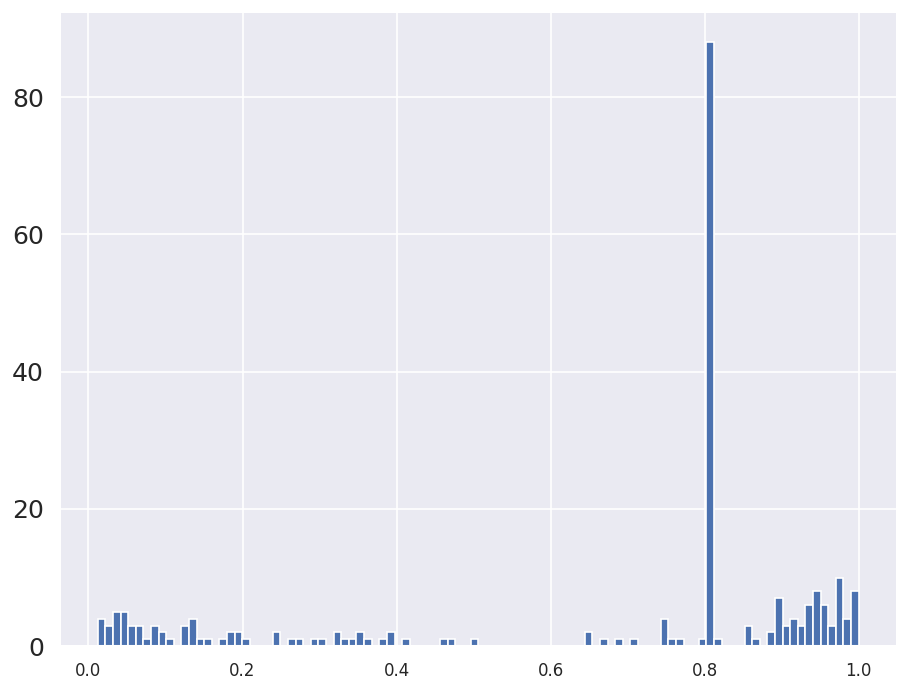

In [164]:

plt.hist(pred, bins=100)
plt.show()